## imports

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nibabel as nib
import os
import sys
from os import listdir
from os.path import isfile, join, exists
from scipy.spatial.distance import pdist, squareform, cosine, euclidean, mahalanobis
from statsmodels.stats.multitest import multipletests
import scipy.io as sio
import scipy.stats as stats
from PIL import Image
from IPython.core.debugger import set_trace
import scipy.io as sio
import torchvision.datasets as datasets
from tqdm import tqdm
import time
import importlib

sys.path.append('/home/jacobpri/git/RotspaceIT/')

from RotspaceIT import rsatools as rsa
from RotspaceIT import nethook as nethook
from RotspaceIT import nnutils as utils
from RotspaceIT import floc_selectivity

importlib.reload(rsa)
importlib.reload(utils)
importlib.reload(floc_selectivity)

<module 'RotspaceIT.floc_selectivity' from '/home/jacobpri/git/RotspaceIT/RotspaceIT/floc_selectivity.py'>

In [25]:
## hyperparameters
arch = 'alexnet'
trained_on = 'object'
imageset = 'imagefiles-fullset'
img_dim = 224
batch_size = 80
FDR_p = 0.05
save_as = '.npy'
overwrite = False
verbose = True
draw_plots = True

In [26]:
## directory management

home_dir = '/home/jacobpri/git/RotspaceIT/'
data_dir = '/user_data/jacobpri/Project/RotspaceIT/'

# target directory for loading activations
activation_loaddir = join(data_dir,'data','d02_modeling','activations')

# target directory for saving layer-wise pref dicts
prefdict_savedir = join(data_dir,'data','d02_modeling','selectivity')

# folder of image sets
imageset_dir = join(home_dir,'imagesets')

load_arch = arch + '-' + trained_on

dirs = os.listdir(imageset_dir)

found = False
for d in dirs:
    d_ = os.listdir(join(imageset_dir,d))
    if (imageset in d_):
        imageset_dir = join(imageset_dir, d, imageset)
        activation_loaddir = join(activation_loaddir, load_arch, d, imageset, 'dim' + str(img_dim))
        prefdict_savedir = join(prefdict_savedir, load_arch, d, imageset, 'dim' + str(img_dim))
        found = True
        break

if found is False:
    raise ValueError('image set not found')   

# create savedir if it doesn't yet exist 
os.makedirs(prefdict_savedir, exist_ok=True)

print("imageset dir %s\n" % imageset_dir)
print("activation load destination: %s\n" % activation_loaddir)
print("prefdict save destination: %s\n" % prefdict_savedir)

assert(exists(activation_loaddir))
assert(exists(imageset_dir))
assert(exists(prefdict_savedir))
assert(save_as == '.npy' or save_as == '.mat')

imageset dir /home/jacobpri/git/RotspaceIT/imagesets/localizer/imagefiles-fullset

activation load destination: /user_data/jacobpri/Project/RotspaceIT/data/d02_modeling/activations/alexnet-object/localizer/imagefiles-fullset/dim224

prefdict save destination: /user_data/jacobpri/Project/RotspaceIT/data/d02_modeling/selectivity/alexnet-object/localizer/imagefiles-fullset/dim224



In [27]:
layer_names_fn = join(activation_loaddir, 'lay_names_user_fmt_batchsize-' + str(batch_size) + '.npy')
assert(exists(layer_names_fn))

layer_names = np.load(layer_names_fn)

all_types = ['conv','relu','pool','norm','drop','fc','downsample','identity','flatten']
includes = all_types #['conv','fc','relu']#all_types#['relu','conv','fc']#all_types#['conv','fc','relu']#all_types#['conv','relu','fc','relu','norm','drop','pool','flatten']#all_types#['conv','fc']

layers_to_load = []

for i in range(len(layer_names)):
    if any(s in layer_names[i] for s in includes):
        layers_to_load.append(layer_names[i])

print(layers_to_load,'\n')
print('%d layers chosen' % len(layers_to_load))

['1_conv1', '2_relu1', '3_maxpool1', '4_conv2', '5_relu2', '6_maxpool2', '7_conv3', '8_relu3', '9_conv4', '10_relu4', '11_conv5', '12_relu5', '13_maxpool5', '14_avgpool5', '15_drop5', '16_fc6', '17_relu6', '18_drop6', '19_fc7', '20_relu7', '21_fc8'] 

21 layers chosen


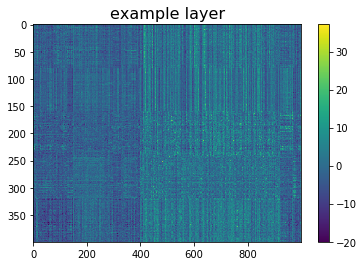

In [29]:
## load batched activations, reshape to 2d, concatenate

# test on a single layer
Y = utils.load_batched_activations(activation_loaddir, ['21_fc8'], batch_size)

if draw_plots is True:
    rsa.plot_matrix(Y,tl = 'example layer',fontsize=16)

In [32]:
## organize category indices

dataset = datasets.ImageFolder(root = imageset_dir)

# print some info -> verify correct # imgs, etc
categ_idx = np.array(dataset.targets)

if imageset == 'vpnl-floc':
    floc_categs = np.array(['adult','body','car','child','corridor','house','instrument','limb','number','scrambled','word'])
    floc_domains = np.array(['faces','bodies','objects','scenes','characters','scrambled'])
    floc_categ_domain_ref = np.array([0,1,2,0,3,3,2,1,4,5,4])
    categ_nimg = 144

    categ_idx = np.repeat(floc_categ_domain_ref,categ_nimg)
else:
    floc_domains = dataset.classes
    
print(floc_domains)

['Bodies', 'Faces', 'Objects', 'Scenes', 'Scrambled']


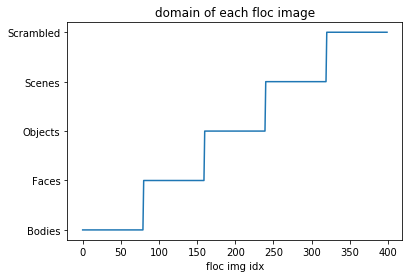

In [33]:
if draw_plots is True:
    ## visualize, for sanity
    plt.figure()
    plt.plot(categ_idx)
    plt.yticks(np.arange(len(floc_domains)),floc_domains);
    plt.xlabel('floc img idx')
    plt.title('domain of each floc image');

Conducting deepnet floc experiments:   0%|          | 0/100 [00:00<?, ?it/s]

1_conv1
size of initial region is 10144 units. comparison is 0 vs. 1
new size of region is 0 units. comparison is 0 vs. 2
new size of region is 0 units. comparison is 0 vs. 3
new size of region is 0 units. comparison is 0 vs. 4
size of initial region is 9694 units. comparison is 1 vs. 0
new size of region is 6722 units. comparison is 1 vs. 2
new size of region is 2410 units. comparison is 1 vs. 3
new size of region is 2161 units. comparison is 1 vs. 4
size of initial region is 110 units. comparison is 2 vs. 0
new size of region is 103 units. comparison is 2 vs. 1
new size of region is 103 units. comparison is 2 vs. 3
new size of region is 39 units. comparison is 2 vs. 4
size of initial region is 11916 units. comparison is 3 vs. 0
new size of region is 7174 units. comparison is 3 vs. 1
new size of region is 6434 units. comparison is 3 vs. 2
new size of region is 6038 units. comparison is 3 vs. 4
size of initial region is 1547 units. comparison is 4 vs. 0
new size of region is 1442 units

Conducting deepnet floc experiments:   5%|▍         | 4.761904761904762/100 [00:08<02:41,  1.70s/it]

2_relu1


/home/jacobpri/Gating/myenv/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/jacobpri/Gating/myenv/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/jacobpri/Gating/myenv/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


size of initial region is 9306 units. comparison is 0 vs. 1
new size of region is 0 units. comparison is 0 vs. 2
new size of region is 0 units. comparison is 0 vs. 3
new size of region is 0 units. comparison is 0 vs. 4
size of initial region is 5382 units. comparison is 1 vs. 0
new size of region is 3077 units. comparison is 1 vs. 2
new size of region is 1690 units. comparison is 1 vs. 3
new size of region is 1456 units. comparison is 1 vs. 4
size of initial region is 81 units. comparison is 2 vs. 0
new size of region is 77 units. comparison is 2 vs. 1
new size of region is 77 units. comparison is 2 vs. 3
new size of region is 42 units. comparison is 2 vs. 4
size of initial region is 10098 units. comparison is 3 vs. 0
new size of region is 6314 units. comparison is 3 vs. 1
new size of region is 3203 units. comparison is 3 vs. 2
new size of region is 1424 units. comparison is 3 vs. 4
size of initial region is 6464 units. comparison is 4 vs. 0
new size of region is 5402 units. comparison

Conducting deepnet floc experiments:  10%|▉         | 9.523809523809524/100 [00:17<02:43,  1.80s/it]

3_maxpool1
size of initial region is 4459 units. comparison is 0 vs. 1
new size of region is 0 units. comparison is 0 vs. 2
new size of region is 0 units. comparison is 0 vs. 3
new size of region is 0 units. comparison is 0 vs. 4
size of initial region is 2247 units. comparison is 1 vs. 0
new size of region is 1183 units. comparison is 1 vs. 2
new size of region is 454 units. comparison is 1 vs. 3
new size of region is 307 units. comparison is 1 vs. 4
size of initial region is 11 units. comparison is 2 vs. 0
new size of region is 11 units. comparison is 2 vs. 1
new size of region is 11 units. comparison is 2 vs. 3
new size of region is 10 units. comparison is 2 vs. 4
size of initial region is 12262 units. comparison is 3 vs. 0
new size of region is 9040 units. comparison is 3 vs. 1
new size of region is 5246 units. comparison is 3 vs. 2
new size of region is 892 units. comparison is 3 vs. 4
size of initial region is 11261 units. comparison is 4 vs. 0


Conducting deepnet floc experiments:  14%|█▍        | 14.285714285714285/100 [00:20<02:02,  1.43s/it]

new size of region is 9185 units. comparison is 4 vs. 1
new size of region is 6345 units. comparison is 4 vs. 2
new size of region is 1996 units. comparison is 4 vs. 3
4_conv2
size of initial region is 8030 units. comparison is 0 vs. 1
new size of region is 14 units. comparison is 0 vs. 2
new size of region is 9 units. comparison is 0 vs. 3
new size of region is 5 units. comparison is 0 vs. 4
size of initial region is 21720 units. comparison is 1 vs. 0
new size of region is 13015 units. comparison is 1 vs. 2
new size of region is 10638 units. comparison is 1 vs. 3
new size of region is 10100 units. comparison is 1 vs. 4
size of initial region is 551 units. comparison is 2 vs. 0
new size of region is 442 units. comparison is 2 vs. 1
new size of region is 365 units. comparison is 2 vs. 3
new size of region is 329 units. comparison is 2 vs. 4
size of initial region is 6794 units. comparison is 3 vs. 0
new size of region is 4258 units. comparison is 3 vs. 1
new size of region is 3463 units

Conducting deepnet floc experiments:  19%|█▉        | 19.047619047619047/100 [00:27<01:56,  1.43s/it]

new size of region is 687 units. comparison is 4 vs. 3
5_relu2
size of initial region is 9127 units. comparison is 0 vs. 1
new size of region is 1 units. comparison is 0 vs. 2
new size of region is 1 units. comparison is 0 vs. 3
new size of region is 1 units. comparison is 0 vs. 4
size of initial region is 5318 units. comparison is 1 vs. 0
new size of region is 3333 units. comparison is 1 vs. 2
new size of region is 2518 units. comparison is 1 vs. 3
new size of region is 2243 units. comparison is 1 vs. 4
size of initial region is 92 units. comparison is 2 vs. 0
new size of region is 76 units. comparison is 2 vs. 1
new size of region is 70 units. comparison is 2 vs. 3
new size of region is 63 units. comparison is 2 vs. 4
size of initial region is 4239 units. comparison is 3 vs. 0
new size of region is 3300 units. comparison is 3 vs. 1
new size of region is 2009 units. comparison is 3 vs. 2
new size of region is 806 units. comparison is 3 vs. 4
size of initial region is 4369 units. compa

Conducting deepnet floc experiments:  24%|██▍       | 23.80952380952381/100 [00:35<01:53,  1.49s/it] 

6_maxpool2
size of initial region is 9294 units. comparison is 0 vs. 1
new size of region is 103 units. comparison is 0 vs. 2
new size of region is 71 units. comparison is 0 vs. 3
new size of region is 40 units. comparison is 0 vs. 4
size of initial region is 2347 units. comparison is 1 vs. 0
new size of region is 1646 units. comparison is 1 vs. 2
new size of region is 1328 units. comparison is 1 vs. 3
new size of region is 1050 units. comparison is 1 vs. 4
size of initial region is 60 units. comparison is 2 vs. 0
new size of region is 39 units. comparison is 2 vs. 1
new size of region is 26 units. comparison is 2 vs. 3
new size of region is 16 units. comparison is 2 vs. 4
size of initial region is 2320 units. comparison is 3 vs. 0
new size of region is 1870 units. comparison is 3 vs. 1
new size of region is 1172 units. comparison is 3 vs. 2
new size of region is 312 units. comparison is 3 vs. 4
size of initial region is 4831 units. comparison is 4 vs. 0
new size of region is 4145 unit

Conducting deepnet floc experiments:  29%|██▊       | 28.571428571428573/100 [00:37<01:23,  1.17s/it]

new size of region is 3208 units. comparison is 4 vs. 2
new size of region is 1952 units. comparison is 4 vs. 3
7_conv3
size of initial region is 3728 units. comparison is 0 vs. 1
new size of region is 51 units. comparison is 0 vs. 2
new size of region is 27 units. comparison is 0 vs. 3
new size of region is 11 units. comparison is 0 vs. 4
size of initial region is 25257 units. comparison is 1 vs. 0
new size of region is 17708 units. comparison is 1 vs. 2
new size of region is 11583 units. comparison is 1 vs. 3
new size of region is 11080 units. comparison is 1 vs. 4
size of initial region is 2190 units. comparison is 2 vs. 0
new size of region is 793 units. comparison is 2 vs. 1
new size of region is 253 units. comparison is 2 vs. 3
new size of region is 211 units. comparison is 2 vs. 4
size of initial region is 20640 units. comparison is 3 vs. 0
new size of region is 8250 units. comparison is 3 vs. 1
new size of region is 5584 units. comparison is 3 vs. 2
new size of region is 3231 u

Conducting deepnet floc experiments:  33%|███▎      | 33.333333333333336/100 [00:41<01:11,  1.07s/it]

8_relu3
size of initial region is 3293 units. comparison is 0 vs. 1
new size of region is 2 units. comparison is 0 vs. 2
new size of region is 0 units. comparison is 0 vs. 3
new size of region is 0 units. comparison is 0 vs. 4
size of initial region is 5401 units. comparison is 1 vs. 0
new size of region is 3653 units. comparison is 1 vs. 2
new size of region is 2968 units. comparison is 1 vs. 3
new size of region is 2788 units. comparison is 1 vs. 4
size of initial region is 19 units. comparison is 2 vs. 0
new size of region is 11 units. comparison is 2 vs. 1
new size of region is 7 units. comparison is 2 vs. 3
new size of region is 4 units. comparison is 2 vs. 4
size of initial region is 3273 units. comparison is 3 vs. 0
new size of region is 2389 units. comparison is 3 vs. 1
new size of region is 1527 units. comparison is 3 vs. 2
new size of region is 521 units. comparison is 3 vs. 4
size of initial region is 3732 units. comparison is 4 vs. 0
new size of region is 3283 units. compar

Conducting deepnet floc experiments:  38%|███▊      | 38.095238095238095/100 [00:45<01:03,  1.03s/it]

9_conv4
size of initial region is 6349 units. comparison is 0 vs. 1
new size of region is 550 units. comparison is 0 vs. 2
new size of region is 226 units. comparison is 0 vs. 3
new size of region is 181 units. comparison is 0 vs. 4
size of initial region is 13694 units. comparison is 1 vs. 0
new size of region is 10632 units. comparison is 1 vs. 2
new size of region is 8178 units. comparison is 1 vs. 3
new size of region is 7653 units. comparison is 1 vs. 4
size of initial region is 1156 units. comparison is 2 vs. 0
new size of region is 331 units. comparison is 2 vs. 1
new size of region is 88 units. comparison is 2 vs. 3
new size of region is 47 units. comparison is 2 vs. 4
size of initial region is 10145 units. comparison is 3 vs. 0
new size of region is 5644 units. comparison is 3 vs. 1
new size of region is 4040 units. comparison is 3 vs. 2
new size of region is 1759 units. comparison is 3 vs. 4
size of initial region is 8484 units. comparison is 4 vs. 0
new size of region is 580

Conducting deepnet floc experiments:  43%|████▎     | 42.857142857142854/100 [00:48<00:51,  1.10it/s]

new size of region is 4527 units. comparison is 4 vs. 2
new size of region is 1692 units. comparison is 4 vs. 3
10_relu4
size of initial region is 3122 units. comparison is 0 vs. 1
new size of region is 41 units. comparison is 0 vs. 2
new size of region is 25 units. comparison is 0 vs. 3
new size of region is 14 units. comparison is 0 vs. 4
size of initial region is 5817 units. comparison is 1 vs. 0
new size of region is 4228 units. comparison is 1 vs. 2
new size of region is 3565 units. comparison is 1 vs. 3
new size of region is 3397 units. comparison is 1 vs. 4
size of initial region is 114 units. comparison is 2 vs. 0
new size of region is 51 units. comparison is 2 vs. 1
new size of region is 28 units. comparison is 2 vs. 3
new size of region is 16 units. comparison is 2 vs. 4
size of initial region is 3355 units. comparison is 3 vs. 0
new size of region is 2539 units. comparison is 3 vs. 1
new size of region is 1509 units. comparison is 3 vs. 2
new size of region is 529 units. com

Conducting deepnet floc experiments:  48%|████▊     | 47.61904761904761/100 [00:51<00:42,  1.23it/s] 

new size of region is 2293 units. comparison is 4 vs. 2
new size of region is 826 units. comparison is 4 vs. 3
11_conv5
size of initial region is 15837 units. comparison is 0 vs. 1
new size of region is 1993 units. comparison is 0 vs. 2
new size of region is 1083 units. comparison is 0 vs. 3
new size of region is 778 units. comparison is 0 vs. 4
size of initial region is 6833 units. comparison is 1 vs. 0
new size of region is 4986 units. comparison is 1 vs. 2
new size of region is 3926 units. comparison is 1 vs. 3
new size of region is 3669 units. comparison is 1 vs. 4
size of initial region is 1625 units. comparison is 2 vs. 0
new size of region is 889 units. comparison is 2 vs. 1
new size of region is 261 units. comparison is 2 vs. 3
new size of region is 177 units. comparison is 2 vs. 4
size of initial region is 7140 units. comparison is 3 vs. 0
new size of region is 5380 units. comparison is 3 vs. 1
new size of region is 3148 units. comparison is 3 vs. 2
new size of region is 1167 

Conducting deepnet floc experiments:  52%|█████▏    | 52.38095238095237/100 [00:54<00:35,  1.34it/s]

new size of region is 5460 units. comparison is 4 vs. 2
new size of region is 2599 units. comparison is 4 vs. 3
12_relu5
size of initial region is 2132 units. comparison is 0 vs. 1
new size of region is 216 units. comparison is 0 vs. 2
new size of region is 196 units. comparison is 0 vs. 3
new size of region is 180 units. comparison is 0 vs. 4
size of initial region is 2689 units. comparison is 1 vs. 0
new size of region is 1848 units. comparison is 1 vs. 2
new size of region is 1606 units. comparison is 1 vs. 3
new size of region is 1523 units. comparison is 1 vs. 4
size of initial region is 87 units. comparison is 2 vs. 0
new size of region is 40 units. comparison is 2 vs. 1
new size of region is 37 units. comparison is 2 vs. 3
new size of region is 26 units. comparison is 2 vs. 4
size of initial region is 2220 units. comparison is 3 vs. 0
new size of region is 1903 units. comparison is 3 vs. 1
new size of region is 1057 units. comparison is 3 vs. 2
new size of region is 379 units. c

Conducting deepnet floc experiments:  57%|█████▋    | 57.14285714285713/100 [00:57<00:30,  1.41it/s]

new size of region is 2273 units. comparison is 4 vs. 2
new size of region is 1011 units. comparison is 4 vs. 3
13_maxpool5
size of initial region is 1741 units. comparison is 0 vs. 1
new size of region is 316 units. comparison is 0 vs. 2
new size of region is 246 units. comparison is 0 vs. 3
new size of region is 206 units. comparison is 0 vs. 4
size of initial region is 1328 units. comparison is 1 vs. 0
new size of region is 881 units. comparison is 1 vs. 2
new size of region is 728 units. comparison is 1 vs. 3
new size of region is 682 units. comparison is 1 vs. 4
size of initial region is 269 units. comparison is 2 vs. 0
new size of region is 110 units. comparison is 2 vs. 1
new size of region is 44 units. comparison is 2 vs. 3
new size of region is 31 units. comparison is 2 vs. 4


Conducting deepnet floc experiments:  62%|██████▏   | 61.90476190476189/100 [00:58<00:21,  1.80it/s]

size of initial region is 2365 units. comparison is 3 vs. 0
new size of region is 1845 units. comparison is 3 vs. 1
new size of region is 1003 units. comparison is 3 vs. 2
new size of region is 468 units. comparison is 3 vs. 4
size of initial region is 1730 units. comparison is 4 vs. 0
new size of region is 1393 units. comparison is 4 vs. 1
new size of region is 927 units. comparison is 4 vs. 2
new size of region is 406 units. comparison is 4 vs. 3
14_avgpool5
size of initial region is 1741 units. comparison is 0 vs. 1
new size of region is 316 units. comparison is 0 vs. 2
new size of region is 246 units. comparison is 0 vs. 3
new size of region is 206 units. comparison is 0 vs. 4
size of initial region is 1328 units. comparison is 1 vs. 0
new size of region is 881 units. comparison is 1 vs. 2
new size of region is 728 units. comparison is 1 vs. 3
new size of region is 682 units. comparison is 1 vs. 4
size of initial region is 269 units. comparison is 2 vs. 0
new size of region is 110 

Conducting deepnet floc experiments:  67%|██████▋   | 66.66666666666666/100 [00:58<00:14,  2.24it/s]

size of initial region is 2365 units. comparison is 3 vs. 0
new size of region is 1845 units. comparison is 3 vs. 1
new size of region is 1003 units. comparison is 3 vs. 2
new size of region is 468 units. comparison is 3 vs. 4
size of initial region is 1730 units. comparison is 4 vs. 0
new size of region is 1393 units. comparison is 4 vs. 1
new size of region is 927 units. comparison is 4 vs. 2
new size of region is 406 units. comparison is 4 vs. 3
15_drop5
size of initial region is 1741 units. comparison is 0 vs. 1
new size of region is 316 units. comparison is 0 vs. 2
new size of region is 246 units. comparison is 0 vs. 3
new size of region is 206 units. comparison is 0 vs. 4
size of initial region is 1328 units. comparison is 1 vs. 0
new size of region is 881 units. comparison is 1 vs. 2
new size of region is 728 units. comparison is 1 vs. 3
new size of region is 682 units. comparison is 1 vs. 4
size of initial region is 269 units. comparison is 2 vs. 0
new size of region is 110 uni

Conducting deepnet floc experiments:  71%|███████▏  | 71.42857142857142/100 [00:59<00:10,  2.74it/s]

size of initial region is 2365 units. comparison is 3 vs. 0
new size of region is 1845 units. comparison is 3 vs. 1
new size of region is 1003 units. comparison is 3 vs. 2
new size of region is 468 units. comparison is 3 vs. 4
size of initial region is 1730 units. comparison is 4 vs. 0
new size of region is 1393 units. comparison is 4 vs. 1
new size of region is 927 units. comparison is 4 vs. 2
new size of region is 406 units. comparison is 4 vs. 3
16_fc6


Conducting deepnet floc experiments:  76%|███████▌  | 76.19047619047618/100 [01:00<00:06,  3.46it/s]

size of initial region is 1660 units. comparison is 0 vs. 1
new size of region is 712 units. comparison is 0 vs. 2
new size of region is 502 units. comparison is 0 vs. 3
new size of region is 336 units. comparison is 0 vs. 4
size of initial region is 1333 units. comparison is 1 vs. 0
new size of region is 972 units. comparison is 1 vs. 2
new size of region is 788 units. comparison is 1 vs. 3
new size of region is 696 units. comparison is 1 vs. 4
size of initial region is 863 units. comparison is 2 vs. 0
new size of region is 455 units. comparison is 2 vs. 1
new size of region is 145 units. comparison is 2 vs. 3
new size of region is 103 units. comparison is 2 vs. 4
size of initial region is 1048 units. comparison is 3 vs. 0
new size of region is 644 units. comparison is 3 vs. 1
new size of region is 387 units. comparison is 3 vs. 2
new size of region is 160 units. comparison is 3 vs. 4
size of initial region is 1337 units. comparison is 4 vs. 0
new size of region is 939 units. comparis

Conducting deepnet floc experiments:  81%|████████  | 80.95238095238093/100 [01:00<00:04,  4.25it/s]

size of initial region is 1157 units. comparison is 0 vs. 1
new size of region is 309 units. comparison is 0 vs. 2
new size of region is 243 units. comparison is 0 vs. 3
new size of region is 183 units. comparison is 0 vs. 4
size of initial region is 841 units. comparison is 1 vs. 0
new size of region is 575 units. comparison is 1 vs. 2
new size of region is 487 units. comparison is 1 vs. 3
new size of region is 439 units. comparison is 1 vs. 4
size of initial region is 628 units. comparison is 2 vs. 0
new size of region is 396 units. comparison is 2 vs. 1
new size of region is 116 units. comparison is 2 vs. 3
new size of region is 76 units. comparison is 2 vs. 4
size of initial region is 960 units. comparison is 3 vs. 0
new size of region is 705 units. comparison is 3 vs. 1
new size of region is 303 units. comparison is 3 vs. 2
new size of region is 148 units. comparison is 3 vs. 4
size of initial region is 901 units. comparison is 4 vs. 0
new size of region is 731 units. comparison i

Conducting deepnet floc experiments:  86%|████████▌ | 85.7142857142857/100 [01:01<00:02,  5.05it/s] 

size of initial region is 1157 units. comparison is 0 vs. 1
new size of region is 309 units. comparison is 0 vs. 2
new size of region is 243 units. comparison is 0 vs. 3
new size of region is 183 units. comparison is 0 vs. 4
size of initial region is 841 units. comparison is 1 vs. 0
new size of region is 575 units. comparison is 1 vs. 2
new size of region is 487 units. comparison is 1 vs. 3
new size of region is 439 units. comparison is 1 vs. 4
size of initial region is 628 units. comparison is 2 vs. 0
new size of region is 396 units. comparison is 2 vs. 1
new size of region is 116 units. comparison is 2 vs. 3
new size of region is 76 units. comparison is 2 vs. 4
size of initial region is 960 units. comparison is 3 vs. 0
new size of region is 705 units. comparison is 3 vs. 1
new size of region is 303 units. comparison is 3 vs. 2
new size of region is 148 units. comparison is 3 vs. 4
size of initial region is 901 units. comparison is 4 vs. 0
new size of region is 731 units. comparison i

Conducting deepnet floc experiments:  90%|█████████ | 90.47619047619045/100 [01:01<00:01,  5.88it/s]

size of initial region is 1924 units. comparison is 0 vs. 1
new size of region is 808 units. comparison is 0 vs. 2
new size of region is 473 units. comparison is 0 vs. 3
new size of region is 376 units. comparison is 0 vs. 4
size of initial region is 1151 units. comparison is 1 vs. 0
new size of region is 766 units. comparison is 1 vs. 2
new size of region is 546 units. comparison is 1 vs. 3
new size of region is 512 units. comparison is 1 vs. 4
size of initial region is 660 units. comparison is 2 vs. 0
new size of region is 317 units. comparison is 2 vs. 1
new size of region is 73 units. comparison is 2 vs. 3
new size of region is 56 units. comparison is 2 vs. 4
size of initial region is 1709 units. comparison is 3 vs. 0
new size of region is 1288 units. comparison is 3 vs. 1
new size of region is 1020 units. comparison is 3 vs. 2
new size of region is 680 units. comparison is 3 vs. 4
size of initial region is 1048 units. comparison is 4 vs. 0
new size of region is 837 units. comparis

Conducting deepnet floc experiments:  95%|█████████▌| 95.23809523809521/100 [01:02<00:00,  7.22it/s]

size of initial region is 460 units. comparison is 0 vs. 1
new size of region is 141 units. comparison is 0 vs. 2
new size of region is 120 units. comparison is 0 vs. 3
new size of region is 100 units. comparison is 0 vs. 4
size of initial region is 282 units. comparison is 1 vs. 0
new size of region is 201 units. comparison is 1 vs. 2
new size of region is 191 units. comparison is 1 vs. 3
new size of region is 187 units. comparison is 1 vs. 4
size of initial region is 102 units. comparison is 2 vs. 0
new size of region is 84 units. comparison is 2 vs. 1
new size of region is 54 units. comparison is 2 vs. 3
new size of region is 40 units. comparison is 2 vs. 4
size of initial region is 352 units. comparison is 3 vs. 0
new size of region is 334 units. comparison is 3 vs. 1
new size of region is 164 units. comparison is 3 vs. 2
new size of region is 83 units. comparison is 3 vs. 4
size of initial region is 423 units. comparison is 4 vs. 0
new size of region is 395 units. comparison is 4 

Conducting deepnet floc experiments: 100%|█████████▉| 99.99999999999997/100 [01:02<00:00,  1.60it/s]

size of initial region is 339 units. comparison is 0 vs. 1
new size of region is 138 units. comparison is 0 vs. 2
new size of region is 83 units. comparison is 0 vs. 3
new size of region is 67 units. comparison is 0 vs. 4
size of initial region is 368 units. comparison is 1 vs. 0
new size of region is 223 units. comparison is 1 vs. 2
new size of region is 167 units. comparison is 1 vs. 3
new size of region is 155 units. comparison is 1 vs. 4
size of initial region is 279 units. comparison is 2 vs. 0
new size of region is 159 units. comparison is 2 vs. 1
new size of region is 80 units. comparison is 2 vs. 3
new size of region is 44 units. comparison is 2 vs. 4
size of initial region is 334 units. comparison is 3 vs. 0
new size of region is 239 units. comparison is 3 vs. 1
new size of region is 192 units. comparison is 3 vs. 2
new size of region is 95 units. comparison is 3 vs. 4
size of initial region is 341 units. comparison is 4 vs. 0
new size of region is 262 units. comparison is 4 v

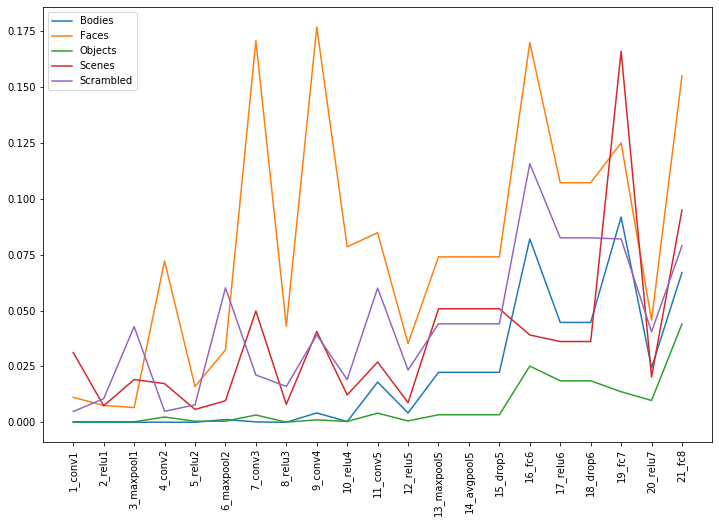

In [35]:
## run deepnet floc experiment, returning a dict with each layer's pref dict
pref_dicts = dict()

with tqdm(total=100,desc='Conducting deepnet floc experiments') as pbar:
    for layer in layers_to_load:
        
        print(layer)
        time.sleep(0.1) 
        
        Y = utils.load_batched_activations(activation_loaddir, layer, batch_size)
        
        pref_dicts[layer] = floc_selectivity.floc_selectivity(Y, categ_idx, FDR_p)
        
        pbar.update(100/len(layers_to_load))

        
if draw_plots is True:
    domain_props = []
    for i in range(len(layers_to_load)):
        domain_props.append(pref_dicts[layers_to_load[i]]['domain_props'])
    domain_props = np.vstack(domain_props)

    plt.figure(figsize=(12,8))
    plt.plot(domain_props);
    plt.legend(floc_domains)
    plt.xticks(np.arange(len(layers_to_load)),np.array(layers_to_load),rotation=90);

In [36]:
## save preference dict for a given locset/model/param combination
save_str = 'layer_pref_dicts_FDR_p_' + str(FDR_p).replace('.','-') + save_as
save_fn = join(prefdict_savedir,save_str)

# saving
if exists(save_fn) and overwrite is False:
    print('skipping, file %s already exists' % save_str)
else:
    if save_as == '.npy':
        np.save(save_fn, pref_dicts)
    elif save_as == '.mat':
        sio.savemat(save_fn, {'pref_dicts': pref_dicts})
    else:
        raise ValueError('no file type specified')

skipping, file layer_pref_dicts_FDR_p_0-05.npy already exists


In [ ]:
print(pref_dicts[layer]['domain_counts'])

In [ ]:
## plots
# selective neurons by domain
plt.figure()
plt.bar(np.arange(len(floc_domains)),pref_dicts['5_conv2']['domain_counts'])
plt.xticks(np.arange(len(floc_domains)),floc_domains,rotation=90);
plt.ylabel('# neurons')
plt.title('# %s selective neurons by domain' % layer);

In [ ]:
domain_props = []
for i in range(len(layers_to_load)):
    domain_props.append(pref_dicts[layers_to_load[i]]['domain_props'])
domain_props = np.vstack(domain_props)
print(domain_props.shape)

plt.figure(figsize=(12,8))
plt.plot(domain_props);
plt.legend(floc_domains)
plt.xticks(np.arange(len(layers_to_load)),np.array(layers_to_load),rotation=90);

In [ ]:
activation_loaddir = '/home/jacobpri/git/RotspaceIT/data/d02_modeling/activations/cornet-z-object/experimental/mc8-lummatched/dim112/'

layer_list = ['9_conv3']




In [ ]:
fmri_dir = join(home_dir,'data','d03_processing','Cohen2017')
brain_data = np.load(join(fmri_dir,'fmri_roi_rsa_subcube.npy'))
roi_list = np.load(join(fmri_dir,'roi_list.npy'))
print(brain_data.shape)
print(roi_list)

FFA_rdv = rsa.rsm2rdm(np.nanmean(np.squeeze(brain_data[5]),axis=0))

rsa.plot_matrix(rsa.v2m(FFA_rdv))

In [ ]:
maps = []

for layer in layer_list:
    
    print(layer)
    Y = utils.load_batched_activations(activation_loaddir, [layer], 240, reshape_to_2D = False)
    #print(Y.shape)

    cohen_order = np.array([1,3,2,5,7,8,6,4])-1
    Y_categ = rsa.collapse_categs_4D(Y, np.repeat(np.arange(8),30))[cohen_order]
    #print(Y_categ.shape)

    Y = Y_categ
    dim = Y.shape
    #print(dim)
    map_dim = (Y.shape[2], Y.shape[3])
    a = np.zeros((8,8))
    map_depth = len(pdist(a,'correlation'))
    corr_map = np.empty(map_dim)
    corr_map[:] = np.nan

    dn_rdvs = np.zeros((map_dim[0],map_dim[1],map_depth))
    #print(dn_rdvs.shape)

    for i in range(map_dim[0]):
        for j in range(map_dim[1]):
            data = np.squeeze(Y[:,:,i,j])
            data_rdv = rsa.rdv(data)
            corr_map[i,j] = rsa.rdvcorr(FFA_rdv, data_rdv)

    maps.append(corr_map)

In [ ]:
rsa.plot_matrix(corr_map)

In [ ]:
plt.figure(figsize=(20,8))
c = 1
for i in range(3):
    plt.subplot(1,3,c)
    rsa.plot_matrix(maps[c-1],vmin=0,vmax=1,tl=layer_list[c-1],fontsize=16)
    c+=1

In [ ]:
maps_ = maps